
# Imports

In [123]:
########################## EDA
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from wordcloud import WordCloud

########################## Preprecessing
#import spacy
import time
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

########################## Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes  import MultinomialNB
from sklearn.naive_bayes  import BernoulliNB
from sklearn.ensemble     import RandomForestClassifier
from xgboost              import XGBClassifier

########################## Machine Learning Evaluation
from sklearn.metrics         import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


pd.set_option('max_colwidth', None)

# Read data

In [124]:
df = pd.read_csv("imdb.csv")

df_train = df.sample(frac = 0.8)
  
df_valid = df.drop(df_train.index)

print("Number of documents in training data: %d" % len(df_train))
print("Number of documents in validation data: %d" % len(df_valid))

Number of documents in training data: 20000
Number of documents in validation data: 5000


# EDA
### Target

C:\Users\Abubakr\Anaconda3\envs\ai\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

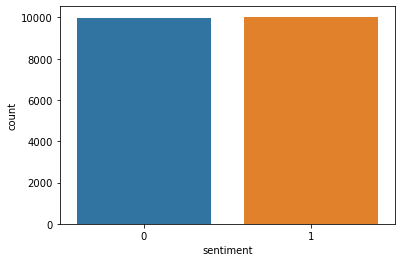

In [125]:
sb.countplot(df_train['sentiment'])

### Text

In [126]:
positive = df[df['sentiment']==0]['review']
negative = df[df['sentiment']==1]['review']

CPU times: total: 23.6 s
Wall time: 24.2 s


Text(0.5, 1.0, 'Negative')

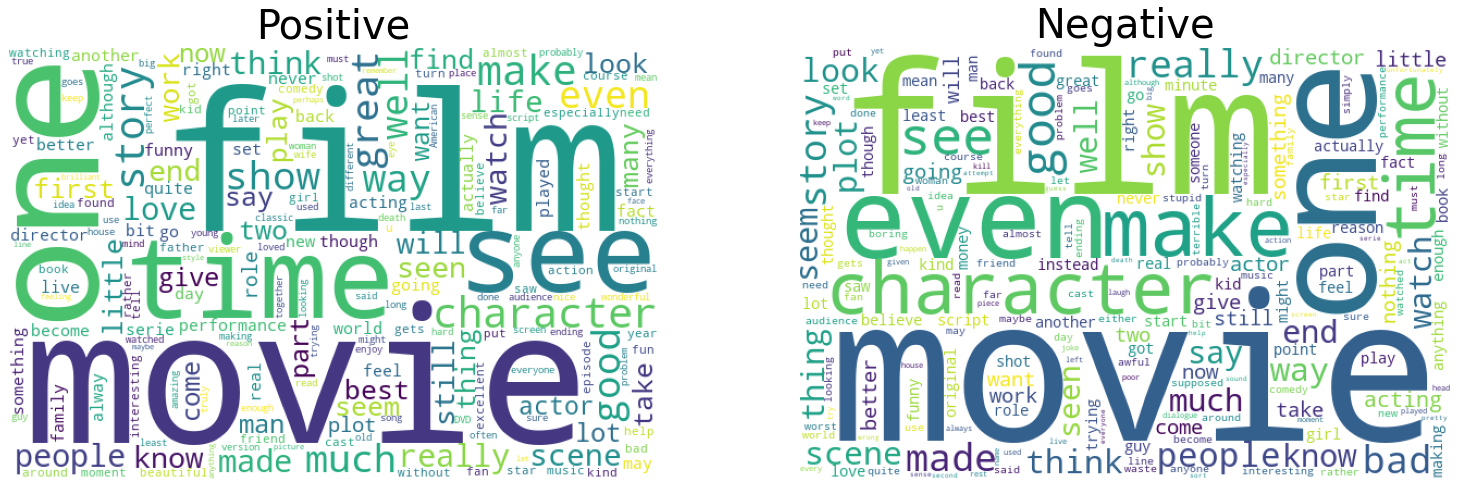

In [127]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive', fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative',fontsize=40);

# NLP Preprocessing

Before we start with any NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Some of the basic text pre-processing techniques includes:

- Make text all **lower case** or **upper case** so that the algorithm does not treat the same words in different cases as different
- **Removing Noise** i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values, common non-sensical text (/n)
- **Tokenization**: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.
- **Stopword Removal**: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words

### More data cleaning steps after tokenization:
- **Stemming**: Stemming is the process of reducing inflected (or sometimes derived) words to their stem, base or root form — generally a written word form. Example if we were to stem the following words: “Stems”, “Stemming”, “Stemmed”, “and Stemtization”, the result would be a single word “stem”.
- **Lemmatization**: A slight variant of stemming is lemmatization. The major difference between these is, that, stemming can often create non-existent words, whereas lemmas are actual words. So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma. Examples of Lemmatization are that “run” is a base form for words like “running” or “ran” or that the word “better” and “good” are in the same lemma so they are considered the same.
- **Parts of speech** tagging
- Create **bi-grams** or tri-grams And more...

However, it is not necessary that you would need to use all these steps. The usage depends on your problem at hand. Sometimes removal of stop words helps while at other times, this might not help.Here is a nice table taken from the blog titled: [All you need to know about Text Preprocessing for Machine Learning & NLP](https://kavita-ganesan.com/text-preprocessing-tutorial) that summarizes how much preprocessing you should be performing on your text data:

# <center> Toy Example

In [128]:
texts = [
    'Hello this is an sentence',
    'Hello this is another sentence',
    'Hello Hello Hello, this is mellow'
]

### Bag Of Words (BOW)

In [129]:
# create a CountVectorizer instance
# fit tranform the text with it
# get the features+

bow = CountVectorizer()
texts_bow = bow.fit_transform(texts)
tokens = bow.get_feature_names_out()
pd.DataFrame(data=texts_bow.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,an,another,hello,is,mellow,sentence,this
Text 1,1,0,1,1,0,1,1
Text 2,0,1,1,1,0,1,1
Text 3,0,0,3,1,1,0,1


### Bag Of Words (BOW) + ngram

In [130]:
#do the same approach but using a range in the count vectorizer
bow = CountVectorizer(ngram_range=(3,3))
texts_bow = bow.fit_transform(texts)
tokens = bow.get_feature_names_out()
pd.DataFrame(data=texts_bow.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,hello hello hello,hello hello this,hello this is,is an sentence,is another sentence,this is an,this is another,this is mellow
Text 1,0,0,1,1,0,1,0,0
Text 2,0,0,1,0,1,0,1,0
Text 3,1,1,1,0,0,0,0,1


### TFIDF
A problem with the Bag of Words approach is that highly frequent words start to dominate in the document (e.g. larger score), but may not contain as much “informational content”. Also, it will give more weight to longer documents than shorter documents.

One approach is to rescale the frequency of words by how often they appear in all documents so that the scores for frequent words like “the” that are also frequent across all documents are penalized. This approach to scoring is called Term Frequency-Inverse Document Frequency, or TF-IDF for short, where:

- **Term Frequency**: is a scoring of the frequency of the word in the current document.
- **Inverse Document Frequency**: is a scoring of how rare the word is across documents.

In [131]:
#Same approach for the TfidfVectorizer
tfidf = TfidfVectorizer()
texts_tfidf =tfidf.fit_transform(texts)
tokens = tfidf.get_feature_names_out()
pd.DataFrame(data=texts_tfidf.toarray(), index=['Text 1', 'Text 2', "Text 3"], columns=tokens)

,an,another,hello,is,mellow,sentence,this
Text 1,0.617227,0.000000,0.364544,0.364544,0.000000,0.469417,0.364544
Text 2,0.000000,0.617227,0.364544,0.364544,0.000000,0.469417,0.364544
Text 3,0.000000,0.000000,0.805627,0.268542,0.454682,0.000000,0.268542


# <center> Apply to the reviews

In [143]:
df['review'] = df['review'].apply(lambda x: x.lower())
#df['review'] = np.array(df['review'])
X,y = df.review.values, df.sentiment.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

xtrain = df_train['review']
ytrain =df_train['sentiment']

### Bag Of Words 1-gram

In [144]:
%%time
bow_1gram = CountVectorizer(lowercase=True)

train_bow_1gram = bow_1gram.fit_transform(X_train, y_train)
valid_bow_1gram = bow_1gram.transform(X_test)

#'numpy.int64' object has no attribute 'lower'

CPU times: total: 5.62 s
Wall time: 5.66 s


### Bag Of Words 1-2-grams

In [145]:
%%time
bow_2grams = CountVectorizer(ngram_range=(1,2), lowercase=True)
train_bow_2grams = bow_2grams.fit_transform(X_train, y_train)
valid_bow_2grams = bow_2grams.transform(X_test)

CPU times: total: 19.2 s
Wall time: 19.4 s


### TFIDF 1-gram

In [146]:
%%time
tfidf_1gram       = TfidfVectorizer(lowercase=True)
train_tfidf_1gram = tfidf_1gram.fit_transform(X_train, y_train)
valid_tfidf_1gram = tfidf_1gram.transform(X_test)

CPU times: total: 6.12 s
Wall time: 6.22 s


### TFIDF 1-2-grams

In [147]:
%%time
tfidf_2grams      = TfidfVectorizer(ngram_range=(1,2), lowercase=True)
train_tfidf_2grams = tfidf_2grams.fit_transform(X_train,y_train)
valid_tfidf_2grams = tfidf_2grams.transform(X_test)

CPU times: total: 21.7 s
Wall time: 21.9 s


In [148]:
data = [
    ("BOW 1gram",   train_bow_1gram, valid_bow_1gram),
    ("BOW 2grams",  train_bow_2grams, valid_bow_2grams),
    ("TFIDF 1gram", train_tfidf_1gram, valid_tfidf_1gram),
    ("TFIDF 2grams",train_tfidf_2grams, valid_tfidf_2grams)
]

print("BOW 1gram   ", train_bow_1gram.shape)
print("BOW 2grams  ", train_bow_2grams.shape)
print("TFIDF 1gram ", train_tfidf_1gram.shape)
print("TFIDF 2grams", train_tfidf_2grams.shape)

BOW 1gram    (20000, 68480)
BOW 2grams   (20000, 1299401)
TFIDF 1gram  (20000, 68480)
TFIDF 2grams (20000, 1299401)


# <center> ML Models

## Naive Bayes (<1 s)

In [149]:
model =MultinomialNB()
for name, X_train, X_test in data:
    
    #Train a MultinomialNB model and meassure the time
   
    t0 =time.time()
    model.fit(X_train, y_train)
    t = time.time() -t0
    a = accuracy_score(y_test, model.predict(X_test))
    print(name, "\tAccuracy:\t", a, "\tTime:\t", t)

BOW 1gram 	Accuracy:	 0.8514 	Time:	 0.033551692962646484
BOW 2grams 	Accuracy:	 0.8814 	Time:	 0.20945143699645996
TFIDF 1gram 	Accuracy:	 0.8678 	Time:	 0.049869537353515625
TFIDF 2grams 	Accuracy:	 0.8906 	Time:	 0.210860013961792


## Logistic Regression (30s)

In [150]:
log =LogisticRegression(max_iter=700)
for name, X_train, X_test in data:
    
    #Train a LogisticRegression model and meassure the time
   
    t0 =time.time()
    log.fit(X_train, y_train)
    t = time.time() -t0
    a = accuracy_score(y_test, log.predict(X_test))
    print(name, "\tAccuracy:\t", a, "\tTime:\t", t)

BOW 1gram 	Accuracy:	 0.8878 	Time:	 20.32449173927307
BOW 2grams 	Accuracy:	 0.9008 	Time:	 162.48997735977173
TFIDF 1gram 	Accuracy:	 0.8944 	Time:	 3.1143078804016113
TFIDF 2grams 	Accuracy:	 0.8936 	Time:	 28.4012713432312


## Random Forest (10+90+6+22 seconds)

In [151]:
mod =RandomForestClassifier()
for name, X_train, X_test in data:
    
    t0 =time.time()
    mod.fit(X_train, y_train)
    t = time.time() -t0
    a = accuracy_score(y_test, mod.predict(X_test))
    print(name, "\tAccuracy:\t", a, "\tTime:\t", t)

BOW 1gram 	Accuracy:	 0.8498 	Time:	 73.65763401985168
BOW 2grams 	Accuracy:	 0.849 	Time:	 266.4182975292206
TFIDF 1gram 	Accuracy:	 0.837 	Time:	 56.11756253242493
TFIDF 2grams 	Accuracy:	 0.8452 	Time:	 234.06061911582947
